In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/cs7643-deep-learning/project"

/content/drive/MyDrive/cs7643-deep-learning/project


In [3]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b25b1c90-7cb9-8457-7310-5672001e30c7)


In [4]:
!pip install -q -U watermark

In [5]:
!pip install -qq transformers

In [6]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import gc
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 77
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
puns = pd.read_csv("puns.csv")
puns

,label,joke
0,1,i used to be a banker but i lost interest
1,1,i m glad i know sign language it s pretty handy
2,1,i don t trust these stairs because they re alw...
3,1,did you hear about the guy who got hit in the ...
4,1,yesterday i accidentally swallowed some food c...
...,...,...
4821,0,Think much say little write less
4822,0,Though the fool waits the day does not
4823,0,Thrift is better than an annuity
4824,0,Thrive by honesty or remain poor


In [8]:
puns['label'].value_counts()

1    2423
0    2403
Name: label, dtype: int64

In [9]:
pun_yes = puns[puns['label']==1].sample(n=2400)
pun_yes

,label,joke
2357,1,oh what a tangled web we weave on the internet
1368,1,that diet clinic is so successful it would tak...
1440,1,i know a pun about beethoven but i won t say i...
2141,1,after the art attack in the museum the science...
2153,1,we should make a beer commercial it sounds sim...
...,...,...
1459,1,his day job was astronomy but at night time he...
694,1,the railway had a safety problem but tried to ...
490,1,a railroad engineer must be sure not to lose h...
2408,1,beansprouts ok so what are they now then


In [10]:
pun_no = puns[puns['label']==0].sample(n=2400)
pun_no

,label,joke
4403,0,Married couples tell each other a thousand thi...
3442,0,The cause of the accident was not immediately ...
2782,0,If that isn t due process I don t know what is
2896,0,I learned that you don t have to take things l...
2767,0,But a lot of them would see that as a start
...,...,...
3578,0,The English didn t and still don t have a bill...
3127,0,I want to get the girl without putting a gun t...
3199,0,She hopes to go to college and become a nurse ...
3504,0,You don t There s a clock on the stove


In [11]:
puns = pd.concat([pun_no, pun_yes])
puns

,label,joke
4403,0,Married couples tell each other a thousand thi...
3442,0,The cause of the accident was not immediately ...
2782,0,If that isn t due process I don t know what is
2896,0,I learned that you don t have to take things l...
2767,0,But a lot of them would see that as a start
...,...,...
1459,1,his day job was astronomy but at night time he...
694,1,the railway had a safety problem but tried to ...
490,1,a railroad engineer must be sure not to lose h...
2408,1,beansprouts ok so what are they now then


In [12]:
puns['label'].value_counts()

1    2400
0    2400
Name: label, dtype: int64

In [13]:
class_names_puns = ['not pun', 'pun']

In [14]:
shortjokes = pd.read_csv("shortjokes.csv")
shortjokes

,label,joke
0,0,today one kasparov aide reportedly said she wa...
1,1,im scared of trampolines they make me jump.
2,0,white house officials say bush personally noti...
3,0,ms. callaghan’s latest play lascivious somethi...
4,0,the good thing now is we have the farm system ...
...,...,...
347481,0,about visant
347482,0,it is a technology step forward in terms of th...
347483,0,got any of your own
347484,1,the neighbor is wife is gonna be so happy when...


In [15]:
shortjokes['label'].value_counts()

0    173851
1    173635
Name: label, dtype: int64

In [16]:
shortjokes_yes = shortjokes[shortjokes['label']==1].sample(n=20000)
shortjokes_yes

,label,joke
330038,1,i scream you scream we all scream for gelato.
264232,1,i have a great joke newcastle united
44479,1,q why do they have so much trouble with the p...
238986,1,love does not walk away people do.
61453,1,what do you call a japanese pirate j-peg.
...,...,...
340675,1,when my boss asks me if i can take a stab at t...
194575,1,phones - they bring you closer to the people t...
264439,1,dark jokes are my favorite what the first thin...
208350,1,tifu by taking someone else is sandwich at the...


In [17]:
shortjokes_no = shortjokes[shortjokes['label']==0].sample(n=20000)
shortjokes_no

,label,joke
190604,0,yet he is showing no signs of being discouraged.
60276,0,the tents
31415,0,mr gair is defence counsel gordon jackson qc a...
331839,0,perhaps an infrastructure hygiene operative th...
99015,0,we tend all to come together at the weekends r...
...,...,...
187764,0,indianapolis ap - a laboratory technician has ...
253406,0,during the course of operations an armed terro...
221026,0,mnf-i possesses convincing and irrefutable evi...
295403,0,otherwise this is a good time to relax and be ...


In [18]:
shortjokes = pd.concat([shortjokes_no, shortjokes_yes])
shortjokes

,label,joke
190604,0,yet he is showing no signs of being discouraged.
60276,0,the tents
31415,0,mr gair is defence counsel gordon jackson qc a...
331839,0,perhaps an infrastructure hygiene operative th...
99015,0,we tend all to come together at the weekends r...
...,...,...
340675,1,when my boss asks me if i can take a stab at t...
194575,1,phones - they bring you closer to the people t...
264439,1,dark jokes are my favorite what the first thin...
208350,1,tifu by taking someone else is sandwich at the...


In [19]:
shortjokes['label'].value_counts()

1    20000
0    20000
Name: label, dtype: int64

In [20]:
class_names_shortjokes = ['not joke', 'joke']

In [21]:
reddit = pd.read_csv("reddit.csv")
reddit

,label,joke
0,0,When I see lovers' names carved in a tree... ....
1,1,What do you call a cow with 3 legs? Lean beef....
2,0,Hercules had a brother who was way ballsier th...
3,1,"In a crowded city at a bus stop, a beautiful y..."
4,1,My neighbor knocked on my door this morning at...
...,...,...
17078,0,Panda and a Prostitute A panda spent the nig...
17079,0,How do you make a dad shit himself? You pull h...
17080,1,"If you pronounce ""fuck off"" backwards. you say..."
17081,1,A priest has a heart attack... A priest has a ...


In [22]:
reddit['label'].value_counts()

1    9349
0    7734
Name: label, dtype: int64

In [23]:
reddit_yes = reddit[reddit['label']==1].sample(n=7500)
reddit_yes

,label,joke
11314,1,My wife is furious at our next door neighbor w...
717,1,I have to give up spreadsheets for forty days....
8702,1,"Oh, how nice (A joke from my 96 year old great..."
11156,1,"In a crowded city at a bus stop, a beautiful y..."
13495,1,Girlfriend tried to make me have sex on the ho...
...,...,...
3896,1,My dad died this day last year because we didn...
1918,1,A recent study has found that beer contains fe...
15857,1,I made a joke about net neutrality Americans d...
12497,1,"“Father, do you have anything to declare?” A b..."


In [24]:
reddit_no = reddit[reddit['label']==0].sample(n=7500)
reddit_no

,label,joke
10900,0,What's the worst thing about breaking up with ...
15436,0,I think it’s a good idea to use different deod...
10539,0,What are bath bombs for suicidal people? Toast...
2711,0,Today is Pancake Tuesday Crepe Diem!
9073,0,What's green and difficult to see through? Wha...
...,...,...
9978,0,I was teaching my son to cook spaghetti bologn...
11435,0,My wife kept taking her pan collection and wal...
5774,0,"When a midget waves at you, it's called a... m..."
5875,0,What's the opposite of a hot dog? A pupsicle.


In [25]:
reddit = pd.concat([reddit_no, reddit_yes])
reddit

,label,joke
10900,0,What's the worst thing about breaking up with ...
15436,0,I think it’s a good idea to use different deod...
10539,0,What are bath bombs for suicidal people? Toast...
2711,0,Today is Pancake Tuesday Crepe Diem!
9073,0,What's green and difficult to see through? Wha...
...,...,...
3896,1,My dad died this day last year because we didn...
1918,1,A recent study has found that beer contains fe...
15857,1,I made a joke about net neutrality Americans d...
12497,1,"“Father, do you have anything to declare?” A b..."


In [26]:
reddit['label'].value_counts()

1    7500
0    7500
Name: label, dtype: int64

In [27]:
class_names_reddit = ['not funny', 'funny']

In [28]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [29]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [30]:
# token_lens = []

# for txt in puns.joke:
#   tokens = tokenizer.encode(txt, truncation=True)
#   token_lens.append(len(tokens))

In [31]:
# sns.displot(token_lens)
# plt.xlim([0, 50]);
# plt.xlabel('Token count');

In [32]:
# (np.array(token_lens) >= 50).sum()

In [33]:
MAX_LEN = 512
BATCH_SIZE = 8
loss_fn = nn.CrossEntropyLoss().to(device)

In [34]:
class GPReviewDataset(Dataset):

  def __init__(self, jokes, targets, tokenizer, max_len):
    self.jokes = jokes
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.jokes)
  
  def __getitem__(self, item):
    joke = str(self.jokes[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      joke,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'joke': joke,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    jokes=df.joke.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [36]:
test_data_loader_puns = create_data_loader(puns, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader_shortjokes = create_data_loader(shortjokes, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader_reddit = create_data_loader(reddit, tokenizer, MAX_LEN, BATCH_SIZE)

In [37]:
# data_puns = next(iter(test_data_loader_puns))
# data_puns.keys()

In [38]:
# print(data_puns['input_ids'].shape)
# print(data_puns['attention_mask'].shape)
# print(data_puns['targets'].shape)

In [39]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [40]:
class HumorClassifier(nn.Module):

  def __init__(self, n_classes):
    super(HumorClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,  return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [41]:
model = HumorClassifier(len(class_names_puns))
model.load_state_dict(torch.load('best_model_state_72k_spl50_h10_w400_lr1e5_dr30.bin'))
model = model.to(device)

In [42]:
%%time
test_acc_puns, _ = eval_model(
  model,
  test_data_loader_puns,
  loss_fn,
  device,
  len(puns)
)

CPU times: user 51.6 s, sys: 38.7 s, total: 1min 30s
Wall time: 1min 30s


In [43]:
test_acc_puns.item()

0.47250000000000003

In [44]:
%%time
test_acc_shortjokes, _ = eval_model(
  model,
  test_data_loader_shortjokes,
  loss_fn,
  device,
  len(shortjokes)
)

CPU times: user 7min 11s, sys: 5min 20s, total: 12min 31s
Wall time: 12min 30s


In [45]:
test_acc_shortjokes.item()

0.59675

In [46]:
%%time
test_acc_reddit, _ = eval_model(
  model,
  test_data_loader_reddit,
  loss_fn,
  device,
  len(reddit)
)

CPU times: user 2min 41s, sys: 2min, total: 4min 41s
Wall time: 4min 40s


In [47]:
test_acc_reddit.item()

0.5156000000000001

In [48]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  jokes = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["joke"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      jokes.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return jokes, predictions, prediction_probs, real_values

In [49]:
%%time
y_puns, y_pred_puns, y_pred_probs_puns, y_test_puns = get_predictions(
  model,
  test_data_loader_puns
)

CPU times: user 50.8 s, sys: 38.3 s, total: 1min 29s
Wall time: 1min 28s


In [50]:
%%time
y_shortjokes, y_pred_shortjokes, y_pred_probs_shortjokes, y_test_shortjokes = get_predictions(
  model,
  test_data_loader_shortjokes
)

CPU times: user 7min 3s, sys: 5min 16s, total: 12min 19s
Wall time: 12min 18s


In [51]:
%%time
y_reddit, y_pred_reddit, y_pred_probs_reddit, y_test_reddit = get_predictions(
  model,
  test_data_loader_reddit
)

CPU times: user 2min 38s, sys: 1min 59s, total: 4min 37s
Wall time: 4min 36s


In [52]:
print(classification_report(y_test_puns, y_pred_puns, target_names=class_names_puns))

              precision    recall  f1-score   support

     not pun       0.46      0.31      0.37      2400
         pun       0.48      0.64      0.55      2400

    accuracy                           0.47      4800
   macro avg       0.47      0.47      0.46      4800
weighted avg       0.47      0.47      0.46      4800



In [53]:
torch.Tensor.float(y_pred_puns).mean()

tensor(0.6633)

In [54]:
print(classification_report(y_test_shortjokes, y_pred_shortjokes, target_names=class_names_shortjokes))

              precision    recall  f1-score   support

    not joke       0.70      0.34      0.46     20000
        joke       0.56      0.85      0.68     20000

    accuracy                           0.60     40000
   macro avg       0.63      0.60      0.57     40000
weighted avg       0.63      0.60      0.57     40000



In [55]:
torch.Tensor.float(y_pred_shortjokes).mean()

tensor(0.7520)

In [56]:
print(classification_report(y_test_reddit, y_pred_reddit, target_names=class_names_reddit))

              precision    recall  f1-score   support

   not funny       0.64      0.07      0.13      7500
       funny       0.51      0.96      0.66      7500

    accuracy                           0.52     15000
   macro avg       0.57      0.52      0.40     15000
weighted avg       0.57      0.52      0.40     15000



In [57]:
torch.Tensor.float(y_pred_reddit).mean()

tensor(0.9423)

In [58]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True humor')
  plt.xlabel('Predicted humor');

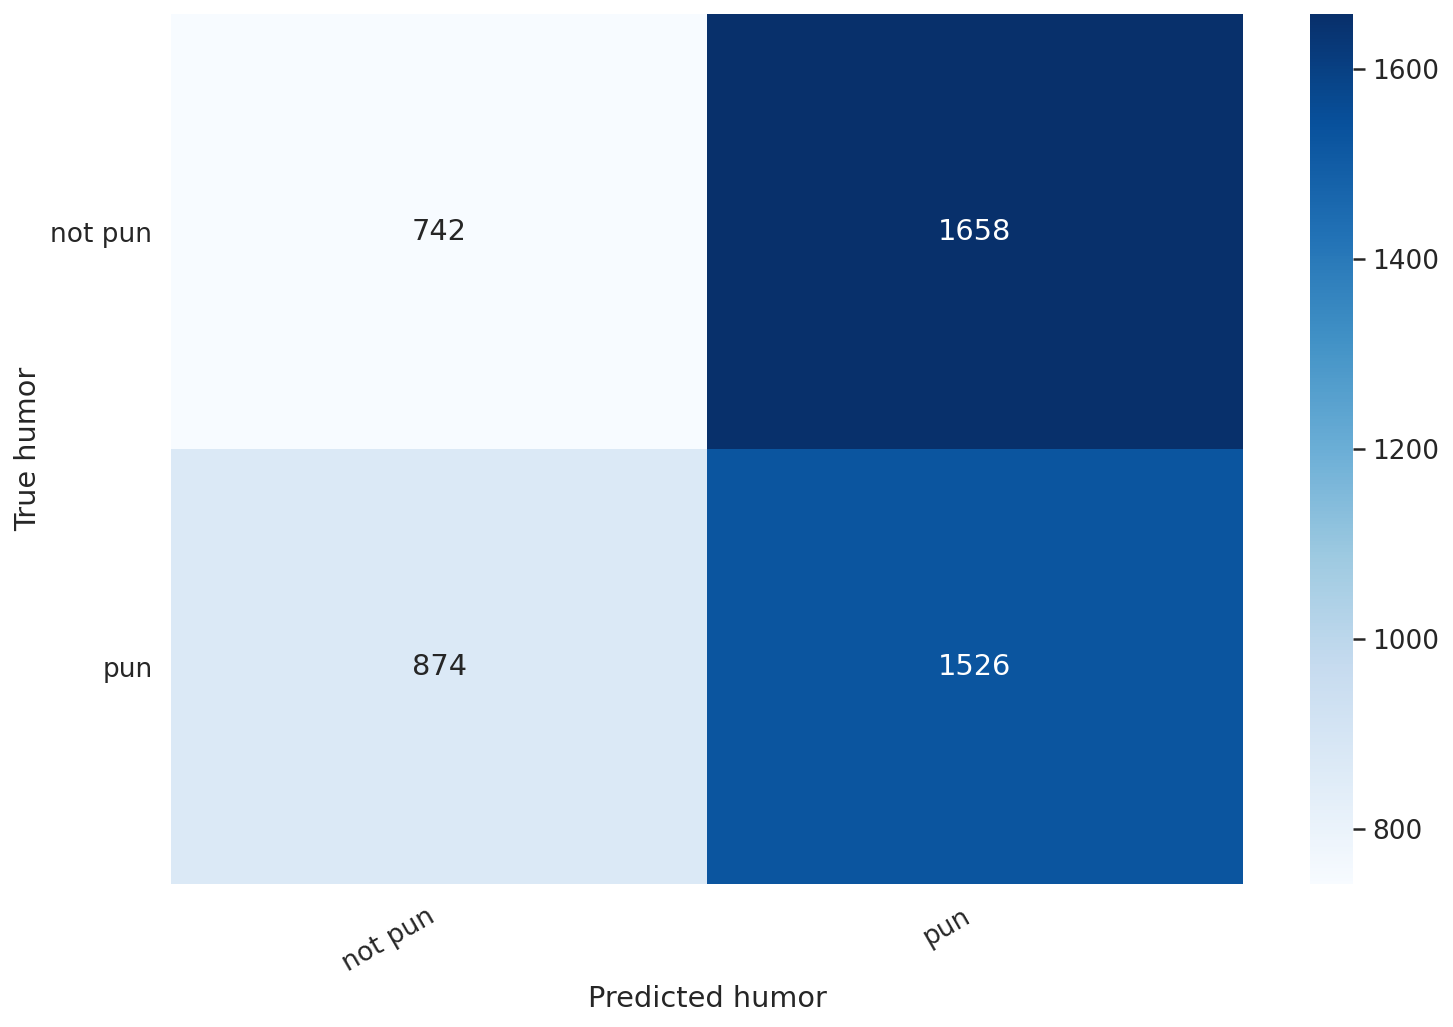

In [59]:
cm_puns = confusion_matrix(y_test_puns, y_pred_puns)
df_cm_puns = pd.DataFrame(cm_puns, index=class_names_puns, columns=class_names_puns)
show_confusion_matrix(df_cm_puns)

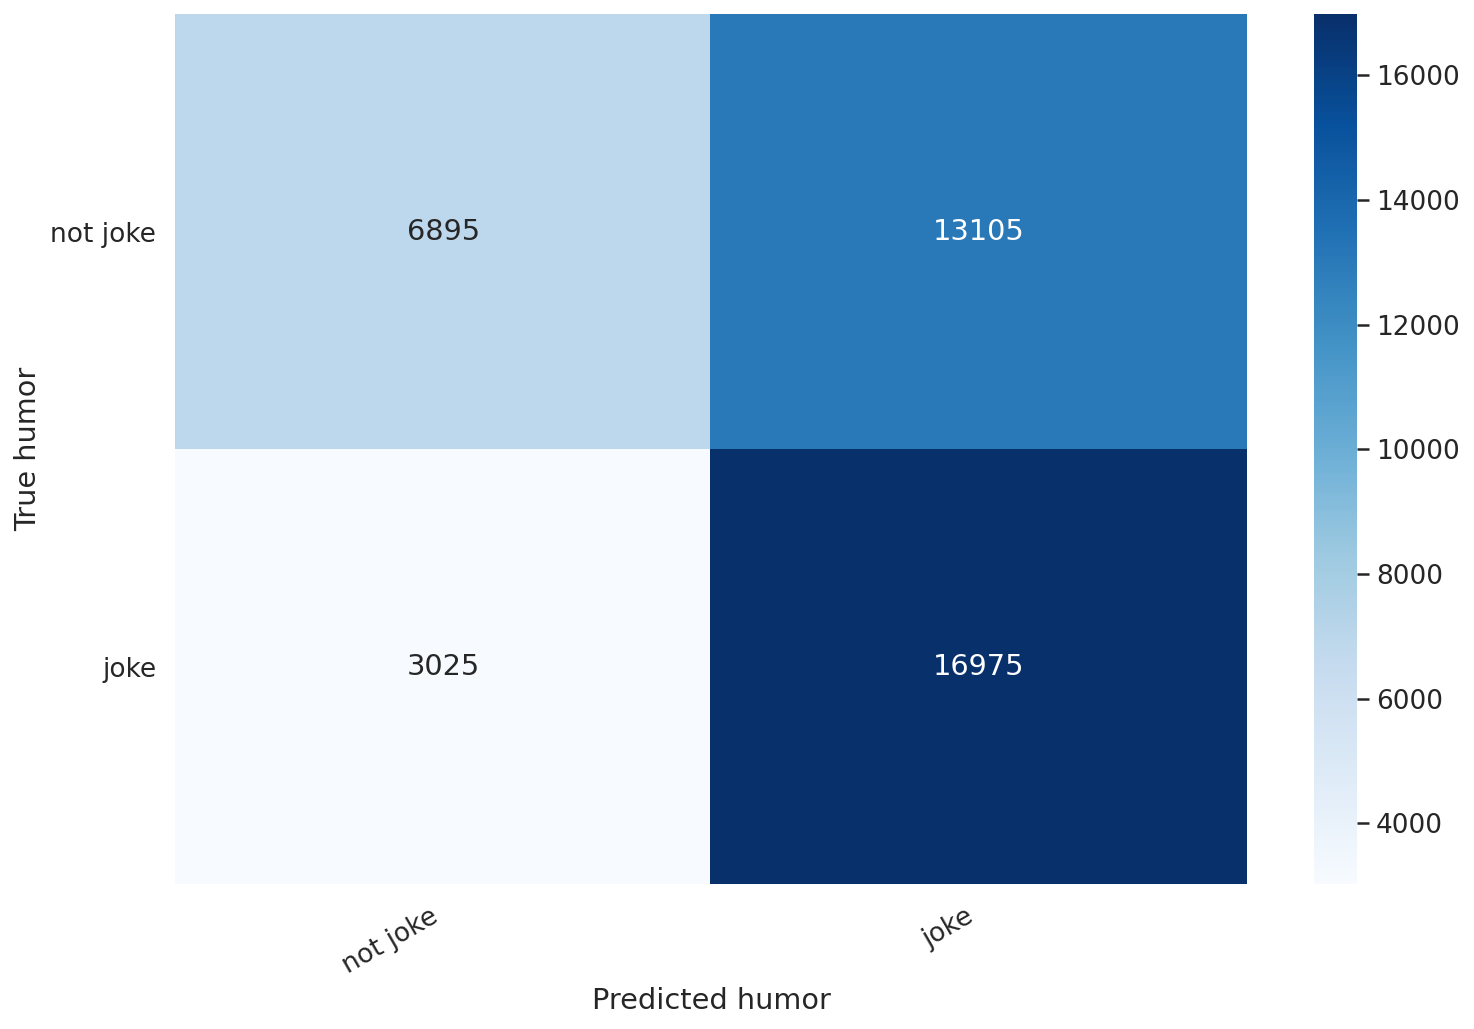

In [60]:
cm_shortjokes = confusion_matrix(y_test_shortjokes, y_pred_shortjokes)
df_cm_shortjokes = pd.DataFrame(cm_shortjokes, index=class_names_shortjokes, columns=class_names_shortjokes)
show_confusion_matrix(df_cm_shortjokes)

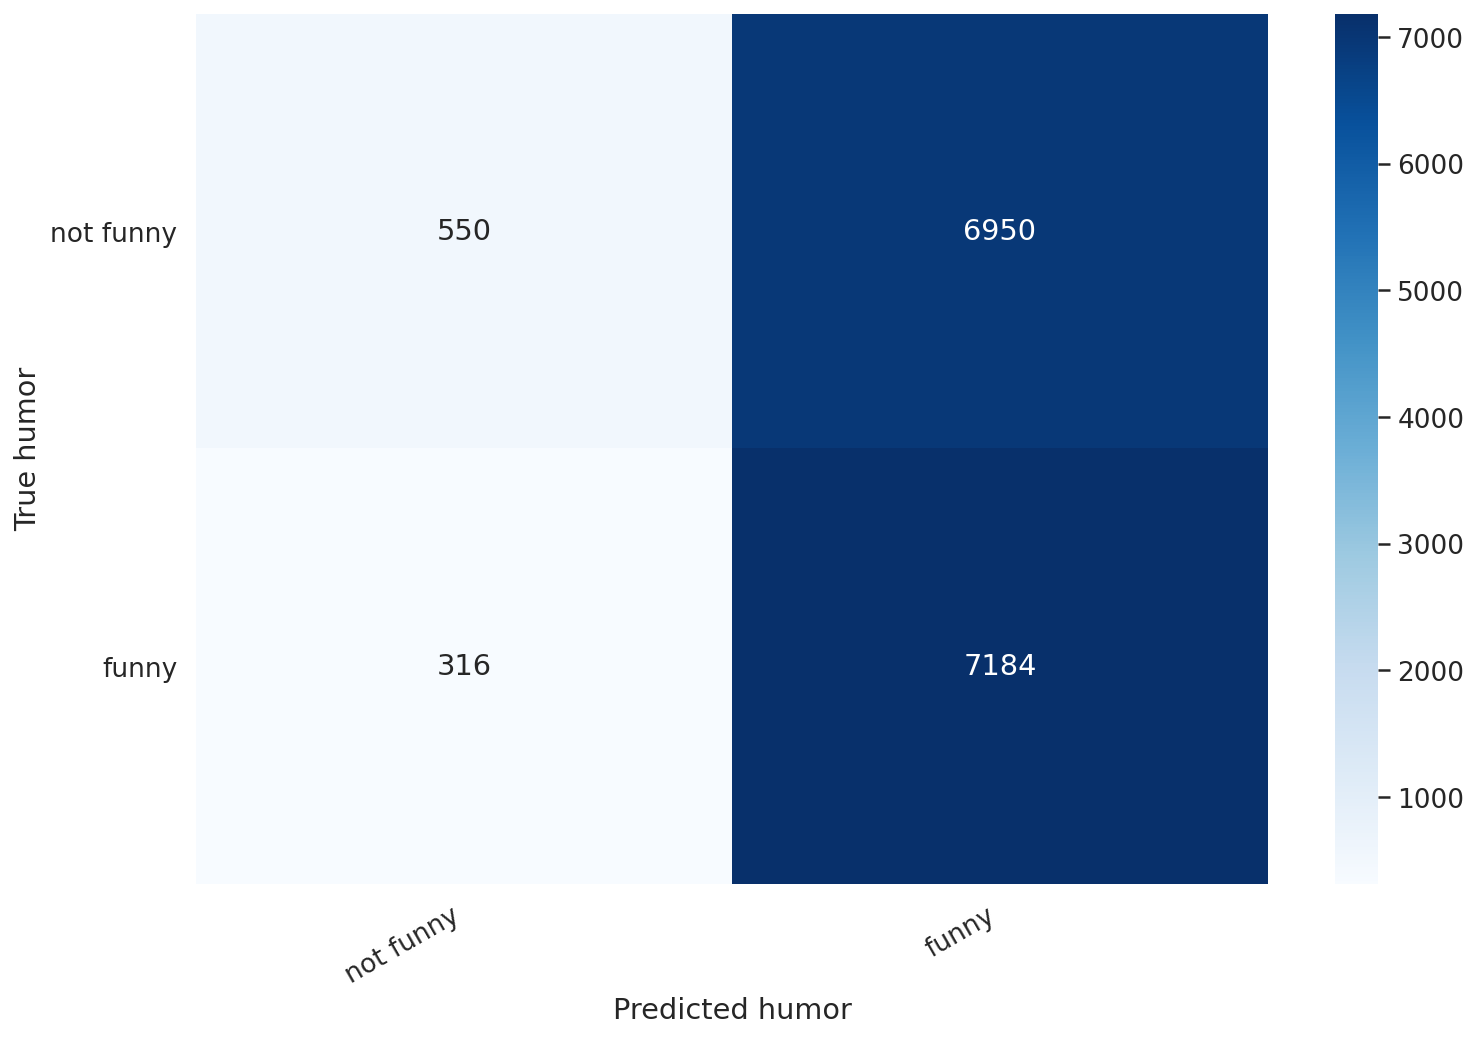

In [61]:
cm_reddit = confusion_matrix(y_test_reddit, y_pred_reddit)
df_cm_reddit = pd.DataFrame(cm_reddit, index=class_names_reddit, columns=class_names_reddit)
show_confusion_matrix(df_cm_reddit)

In [62]:
np.argwhere(y_pred_puns==1)[0][:50]

tensor([ 0,  1,  2,  3,  4,  5,  7,  9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 24, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 41, 43, 44, 45, 47, 48,
        50, 52, 53, 54, 56, 58, 59, 60, 62, 63, 64, 65, 66, 72])

In [63]:
np.argwhere(y_pred_puns==0)[0][:50]

tensor([  6,   8,  10,  11,  23,  25,  26,  35,  36,  39,  40,  42,  46,  49,
         51,  55,  57,  61,  67,  68,  69,  70,  71,  73,  75,  79,  80,  81,
         83,  84,  91,  93,  95, 101, 102, 108, 109, 111, 117, 121, 123, 127,
        131, 132, 133, 134, 135, 142, 144, 147])

In [66]:
idx_puns = 1000

pun = y_puns[idx_puns]
true_sentiment_puns = y_test_puns[idx_puns]
pred_df_puns = pd.DataFrame({
  'class_names': class_names_puns,
  'values': y_pred_probs_puns[idx_puns]
})

In [67]:
np.argwhere(y_pred_shortjokes==1)[0][:50]

tensor([ 2,  3,  5,  7,  8,  9, 12, 13, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30,
        33, 34, 37, 39, 40, 41, 44, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 61,
        62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76])

In [68]:
np.argwhere(y_pred_shortjokes==0)[0][:50]

tensor([  0,   1,   4,   6,  10,  11,  14,  15,  16,  17,  18,  21,  26,  31,
         32,  35,  36,  38,  42,  43,  45,  54,  55,  58,  59,  60,  66,  78,
         79,  80,  81,  83,  84,  87,  88,  90,  98, 100, 101, 103, 107, 109,
        110, 112, 113, 116, 117, 126, 130, 131])

In [69]:
idx_shortjokes = 1000

shortjoke = y_shortjokes[idx_shortjokes]
true_sentiment_shortjokes = y_test_shortjokes[idx_shortjokes]
pred_df_shortjokes = pd.DataFrame({
  'class_names': class_names_shortjokes,
  'values': y_pred_probs_shortjokes[idx_shortjokes]
})

In [70]:
np.argwhere(y_pred_reddit==1)[0][:50]

tensor([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52])

In [71]:
np.argwhere(y_pred_reddit==0)[0][:50]

tensor([  3,  16,  17,  75,  78,  79,  90,  92, 118, 157, 158, 180, 187, 196,
        197, 205, 208, 234, 241, 242, 252, 260, 291, 330, 331, 336, 339, 344,
        374, 378, 389, 390, 430, 441, 464, 474, 481, 508, 536, 543, 546, 550,
        551, 566, 586, 600, 601, 605, 614, 638])

In [72]:
idx_reddit = 5000

redditjoke = y_reddit[idx_reddit]
true_sentiment_reddit = y_test_reddit[idx_reddit]
pred_df_reddit = pd.DataFrame({
  'class_names': class_names_reddit,
  'values': y_pred_probs_reddit[idx_reddit]
})

In [73]:
print("\n".join(wrap(pun)))
print()
print(f'True humor: {class_names_puns[true_sentiment_puns]}')

They weren t shotgun marriages because someone got pregnant although
some of them were

True humor: not pun


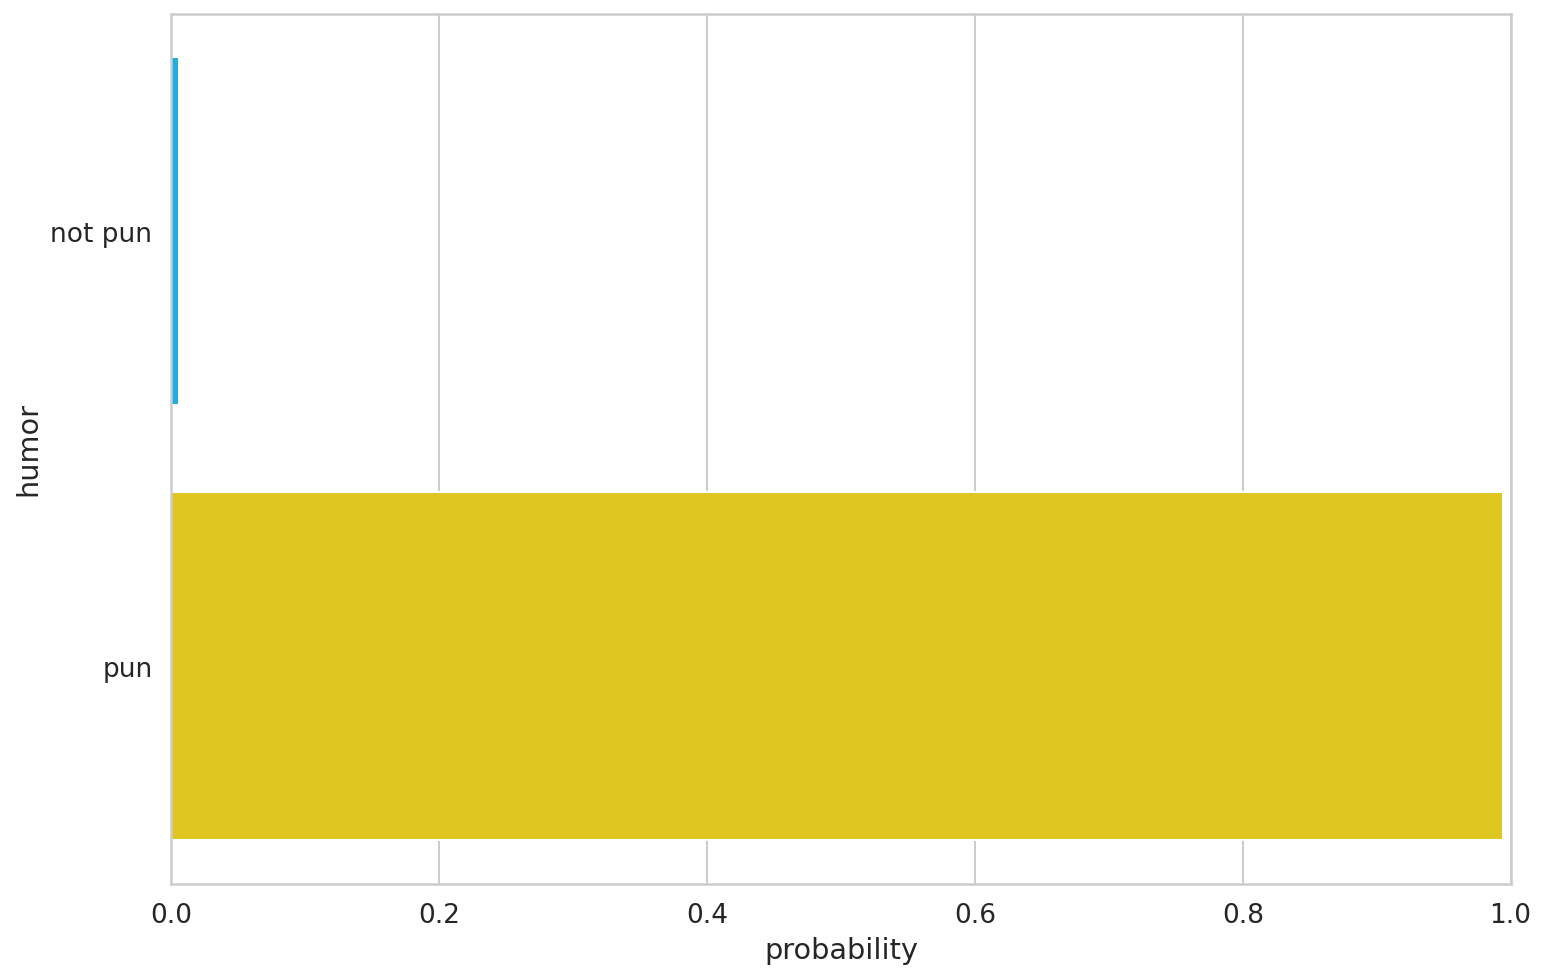

In [74]:
sns.barplot(x='values', y='class_names', data=pred_df_puns, orient='h')
plt.ylabel('humor')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [75]:
print("\n".join(wrap(shortjoke)))
print()
print(f'True humor: {class_names_shortjokes[true_sentiment_shortjokes]}')

this authentic motocross-themed concept is a cooperative effort with
scott waraniak.

True humor: not joke


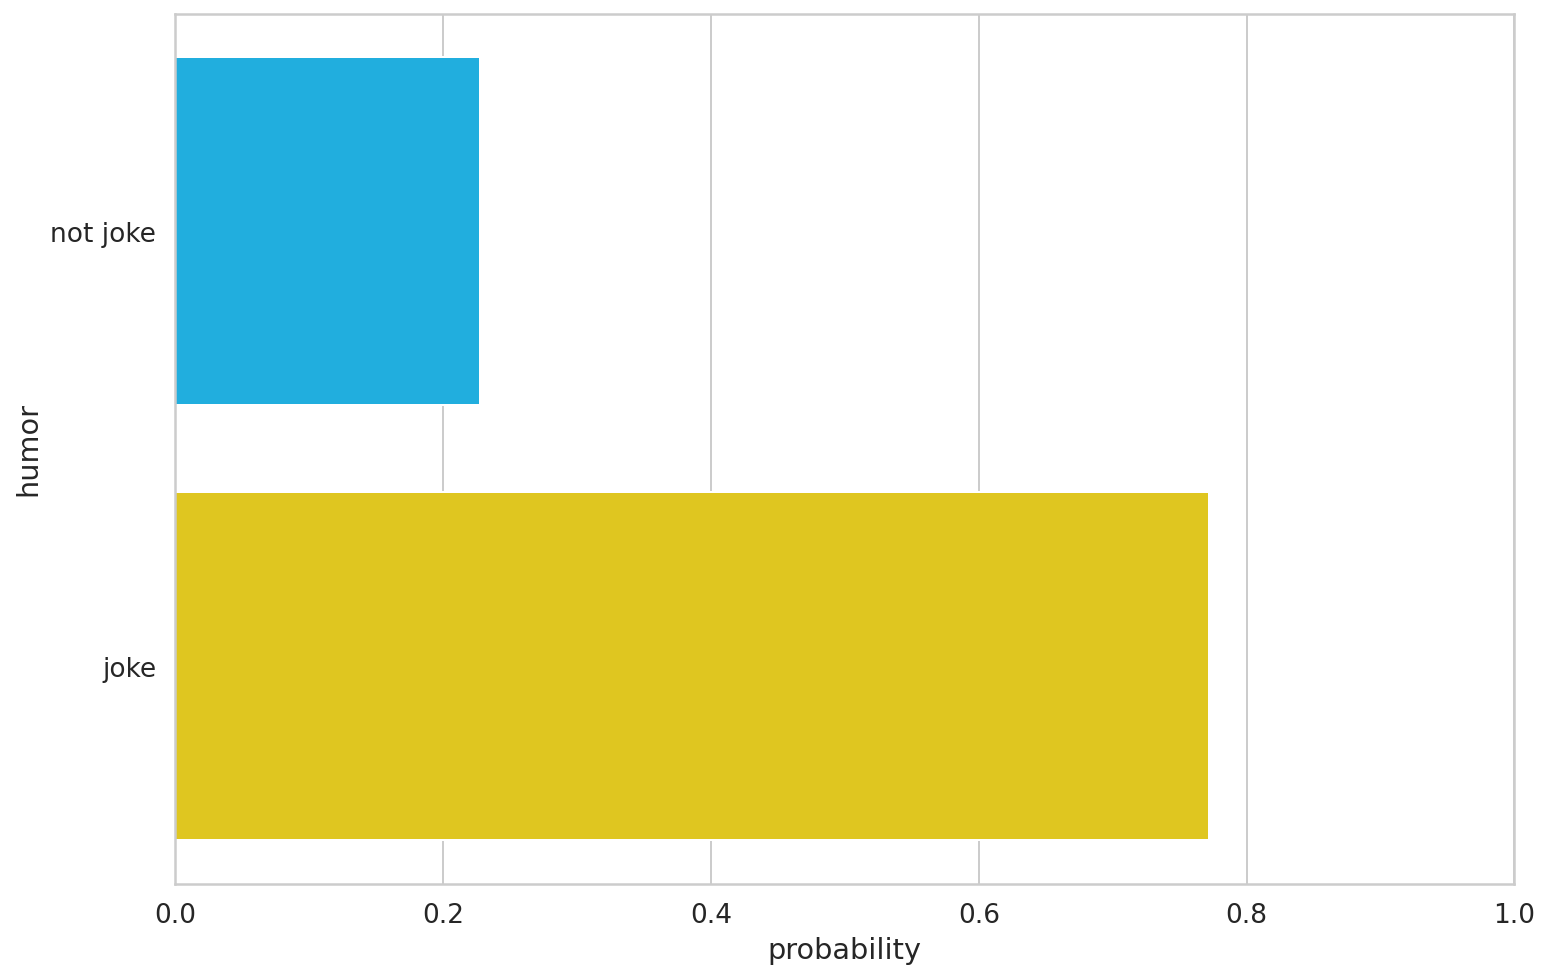

In [76]:
sns.barplot(x='values', y='class_names', data=pred_df_shortjokes, orient='h')
plt.ylabel('humor')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [77]:
print("\n".join(wrap(redditjoke)))
print()
print(f'True humor: {class_names_reddit[true_sentiment_reddit]}')

How Many Frenchmen does it take to defend their country? They don't
know; they've never tried.

True humor: not funny


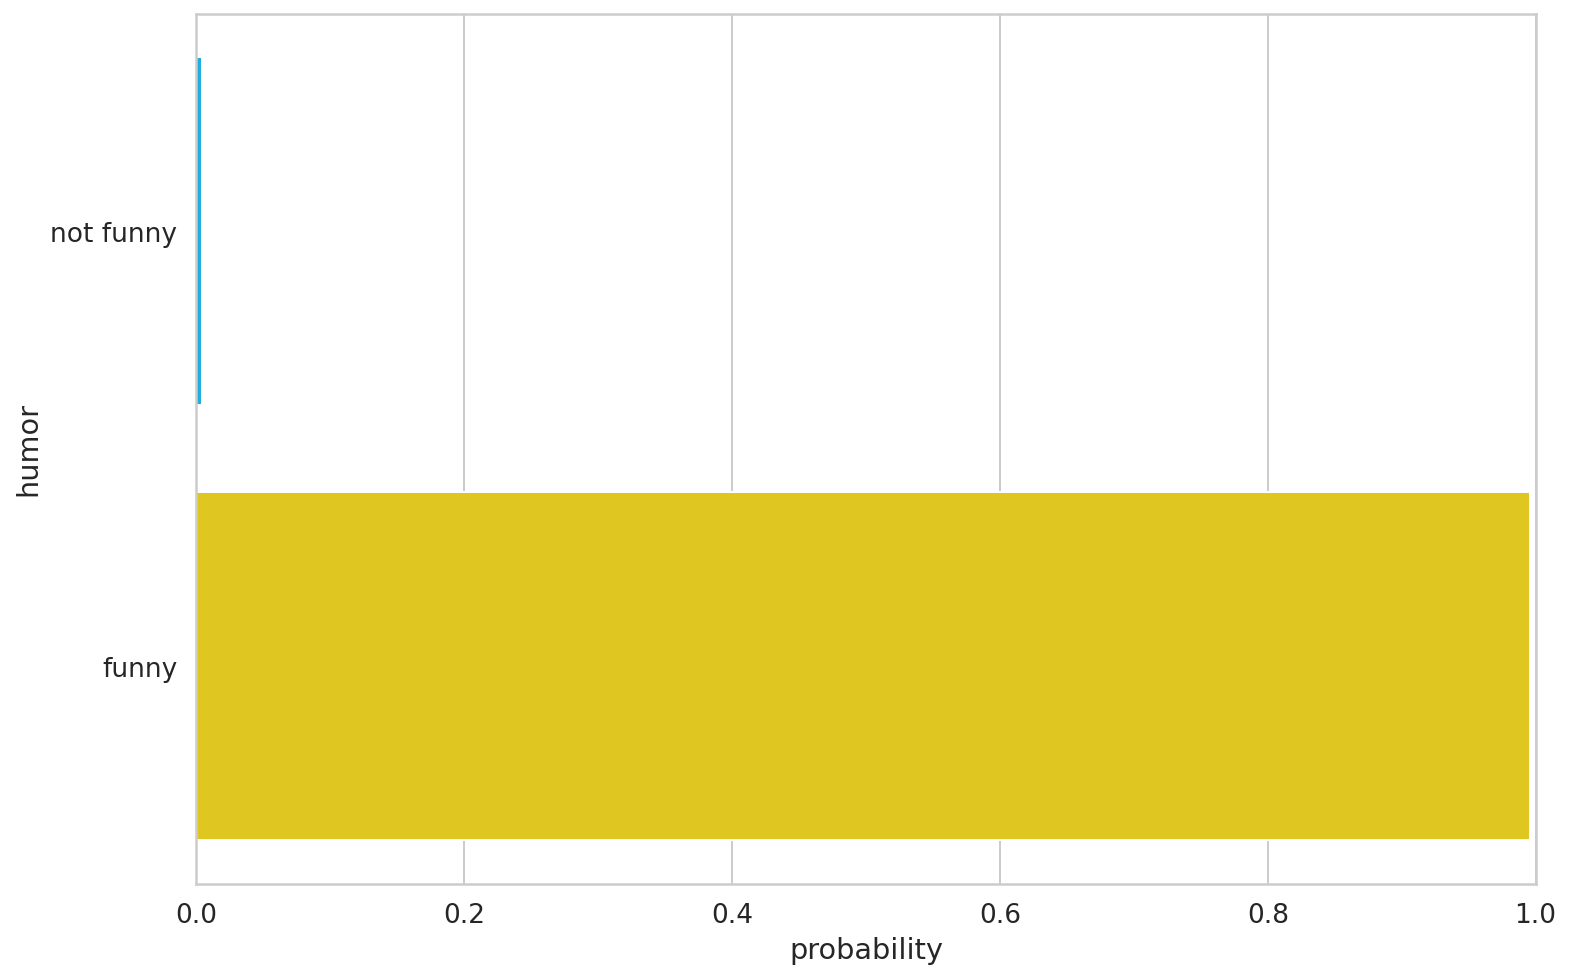

In [78]:
sns.barplot(x='values', y='class_names', data=pred_df_reddit, orient='h')
plt.ylabel('humor')
plt.xlabel('probability')
plt.xlim([0, 1]);